# Pairs trading for BNB and ETH coins

In [6]:
import pycoingecko
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.stattools import acf, pacf, coint

# Initialize CoinGecko API client
coinGecko = pycoingecko.CoinGeckoAPI()

coinGecko.ping()

{'gecko_says': '(V3) To the Moon!'}

In [5]:
#symbols = [i['id'] for i in coinGecko.get_coins_markets('usd')]

symbol = ['bitcoin','ethereum','tether','binancecoin','ripple','cardano']

def get_historical_data(symbol,Ndays:int):
    df = pd.DataFrame()
    for i in symbol:
        data = coinGecko.get_coin_market_chart_by_id(i, 'usd', str(Ndays)+'days',interval = 'daily')
        # Extract the dates and prices from the data
        dates = [data[0] for data in data['prices']]
        # convert unix timestamp to datetime
        dates = [
            datetime.datetime.fromtimestamp(date/1000)
            for date in dates]
        prices = [data[1] for data in data['prices']]
        
        new_df = pd.DataFrame({i:prices})
        new_df = new_df.set_index(pd.Index(dates))
        df = pd.concat([df, new_df], axis = 1)
    
    df = df.iloc[:Ndays,:]
    return df
        
df = get_historical_data(symbol,1825)

print(df.tail())
print(df.head())

                          bitcoin     ethereum    tether  binancecoin  \
2023-11-16 08:00:00  37903.662452  2061.635532  1.000761   253.647814   
2023-11-17 08:00:00  36201.516111  1962.243840  0.999988   242.842704   
2023-11-18 08:00:00  36527.760225  1956.517432  1.000181   244.281692   
2023-11-19 08:00:00  36582.368442  1962.630566  1.000767   244.828397   
2023-11-20 08:00:00  37413.994608  2011.126721  0.999726   246.233603   

                       ripple   cardano  
2023-11-16 08:00:00  0.649902  0.378959  
2023-11-17 08:00:00  0.612338  0.370515  
2023-11-18 08:00:00  0.612726  0.365721  
2023-11-19 08:00:00  0.610660  0.377610  
2023-11-20 08:00:00  0.626991  0.383976  
                         bitcoin    ethereum    tether  binancecoin    ripple  \
2018-11-22 08:00:00  4613.448412  137.173043  0.991084     6.229547  0.449660   
2018-11-23 08:00:00  4307.388732  126.066388  0.986875     5.724390  0.425897   
2018-11-24 08:00:00  4376.904947  124.150296  0.993092     5.62280

<AxesSubplot: >

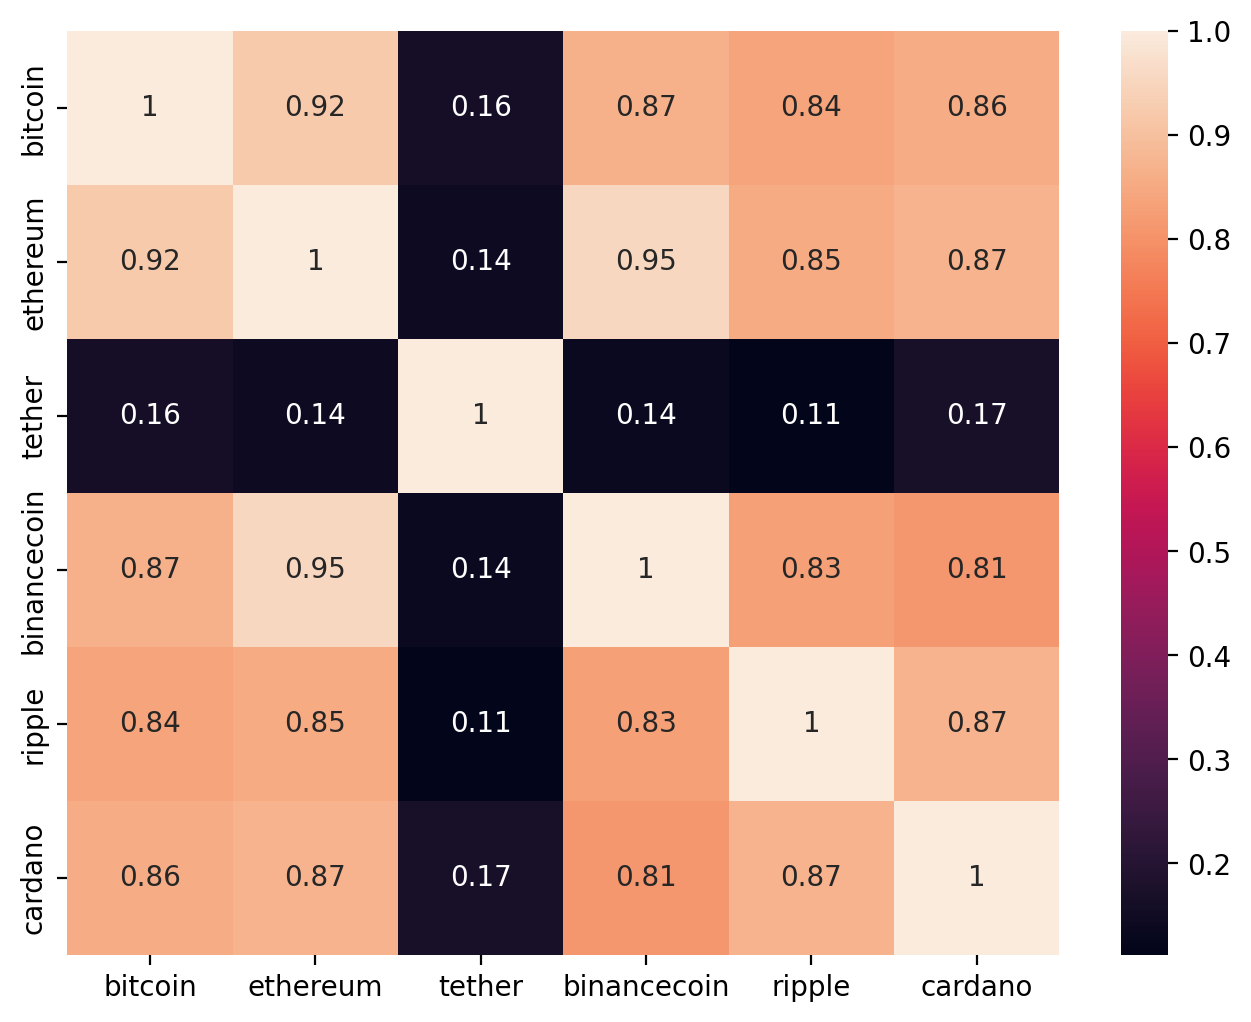

In [7]:
import seaborn as sn
plt.figure(figsize=(8, 6),dpi = 200)
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot = True)

In [8]:
bnb = df['binancecoin']
eth = df['ethereum']
btc = df['bitcoin']

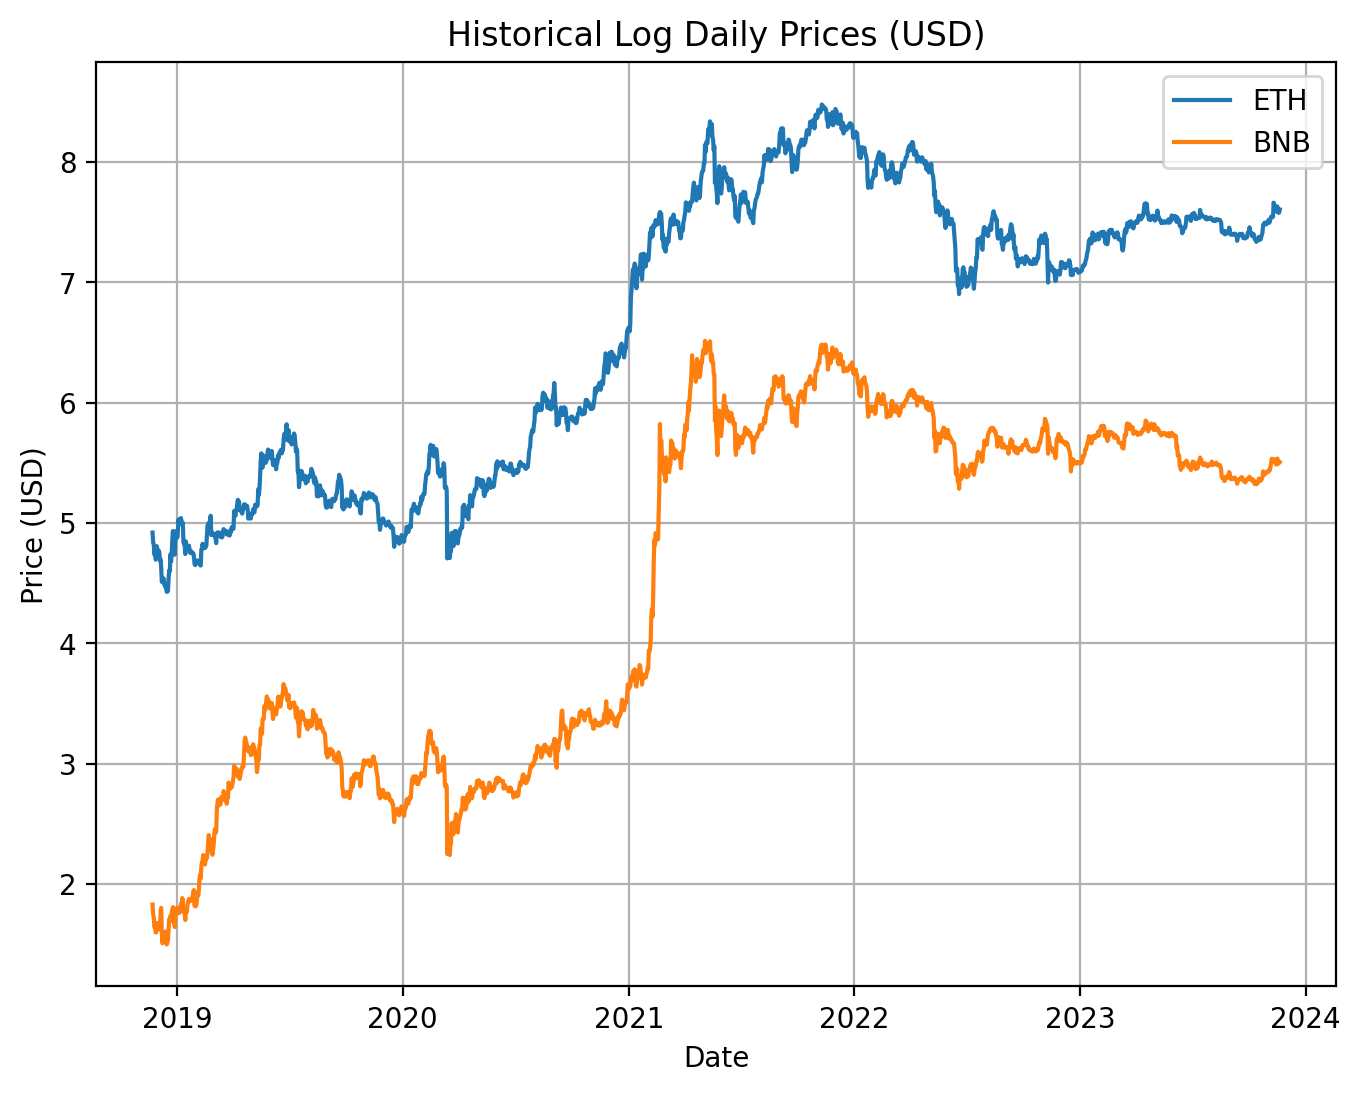

In [9]:
plt.figure(figsize=(8, 6),dpi = 200)
plt.plot(np.log(eth),label = "ETH")
#plt.plot(btc,label = "BTC")
plt.plot(np.log(bnb), label = 'BNB')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Historical Log Daily Prices (USD)')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
#We want to test for cointegration

#Null: No cointegration
result = coint(bnb, eth)
cointegration_t_statistic = result[0]
p_val = result[1]
critical_values_test_statistic_at_1_5_10 = result[2]
print('We want the P val < 0.05 (meaning that cointegration exists)')
print('P value for the augmented Engle-Granger two-step cointegration test is', p_val)

#The time series appear to be cointegrated

We want the P val < 0.05 (meaning that cointegration exists)
P value for the augmented Engle-Granger two-step cointegration test is 0.029170800767227036


In [11]:
import statsmodels.api as sm
model = sm.OLS(eth, sm.add_constant(bnb)).fit()
residuals = model.resid
adf_result = sm.tsa.adfuller(residuals)
p_value = adf_result[1]

if p_value < 0.05:
    print("Cointegration exists.")
else:
    print("No cointegration.")

cointegration_coefficient = model.params['binancecoin']

Cointegration exists.


(array([  1.,   1.,   0.,   4.,  10.,  11.,  10.,  45., 121., 116., 109.,
        653., 265., 246.,  80.,  61.,  34.,  31.,  21.,   6.]),
 array([-1779.57110106, -1629.78983235, -1480.00856365, -1330.22729494,
        -1180.44602623, -1030.66475752,  -880.88348881,  -731.1022201 ,
         -581.3209514 ,  -431.53968269,  -281.75841398,  -131.97714527,
           17.80412344,   167.58539215,   317.36666086,   467.14792956,
          616.92919827,   766.71046698,   916.49173569,  1066.2730044 ,
         1216.05427311]),
 <BarContainer object of 20 artists>)

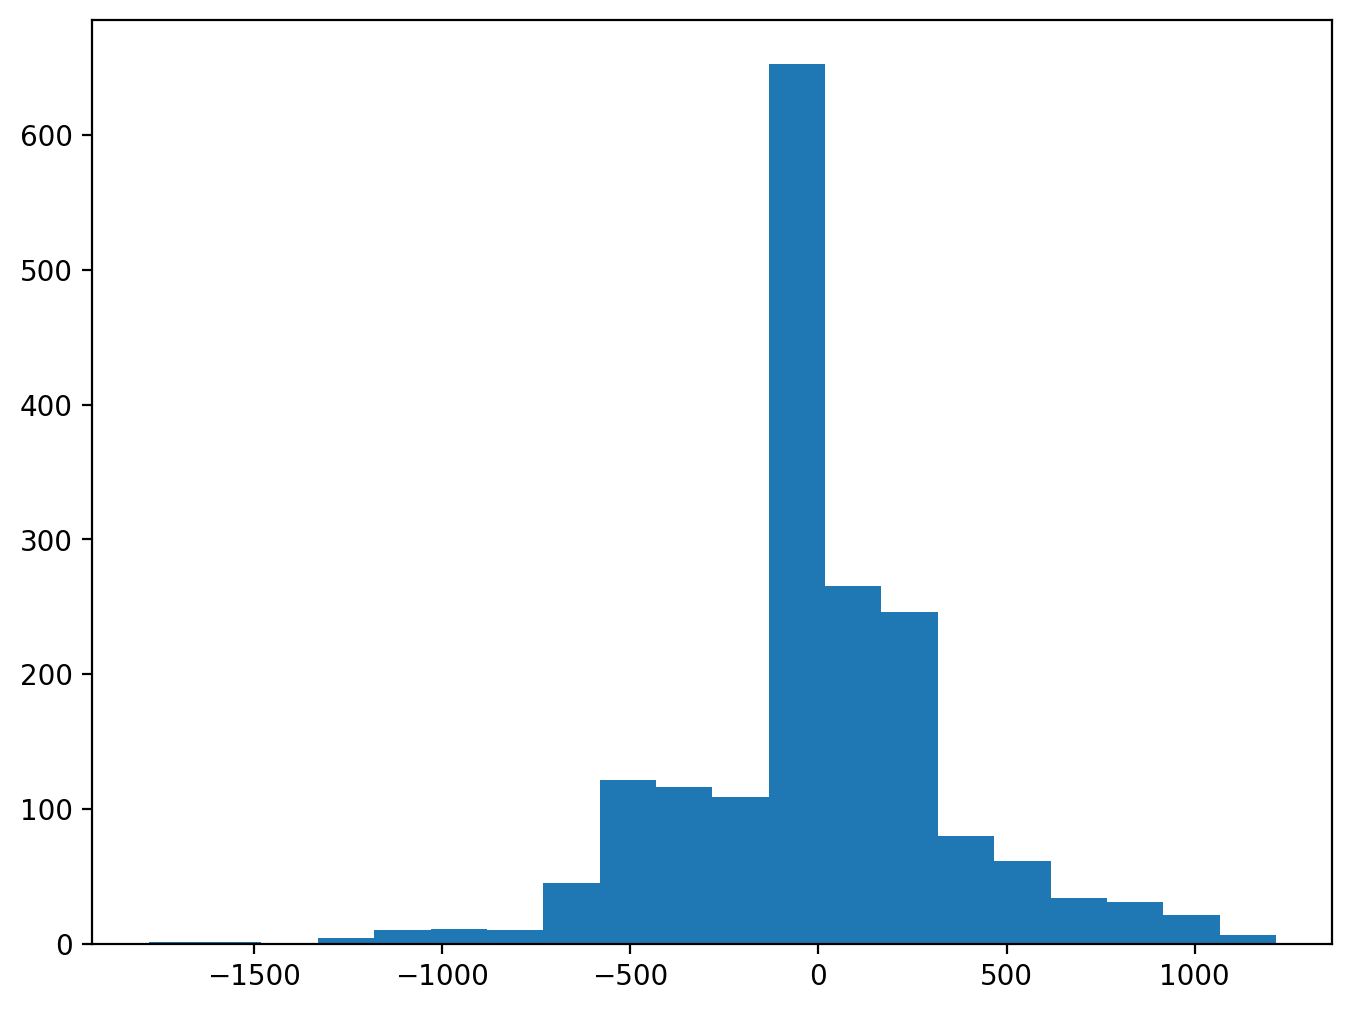

In [12]:
plt.figure(figsize=(8, 6),dpi = 200)
plt.hist(residuals,bins = 20)

Text(0.5, 1.0, 'Zt Process')

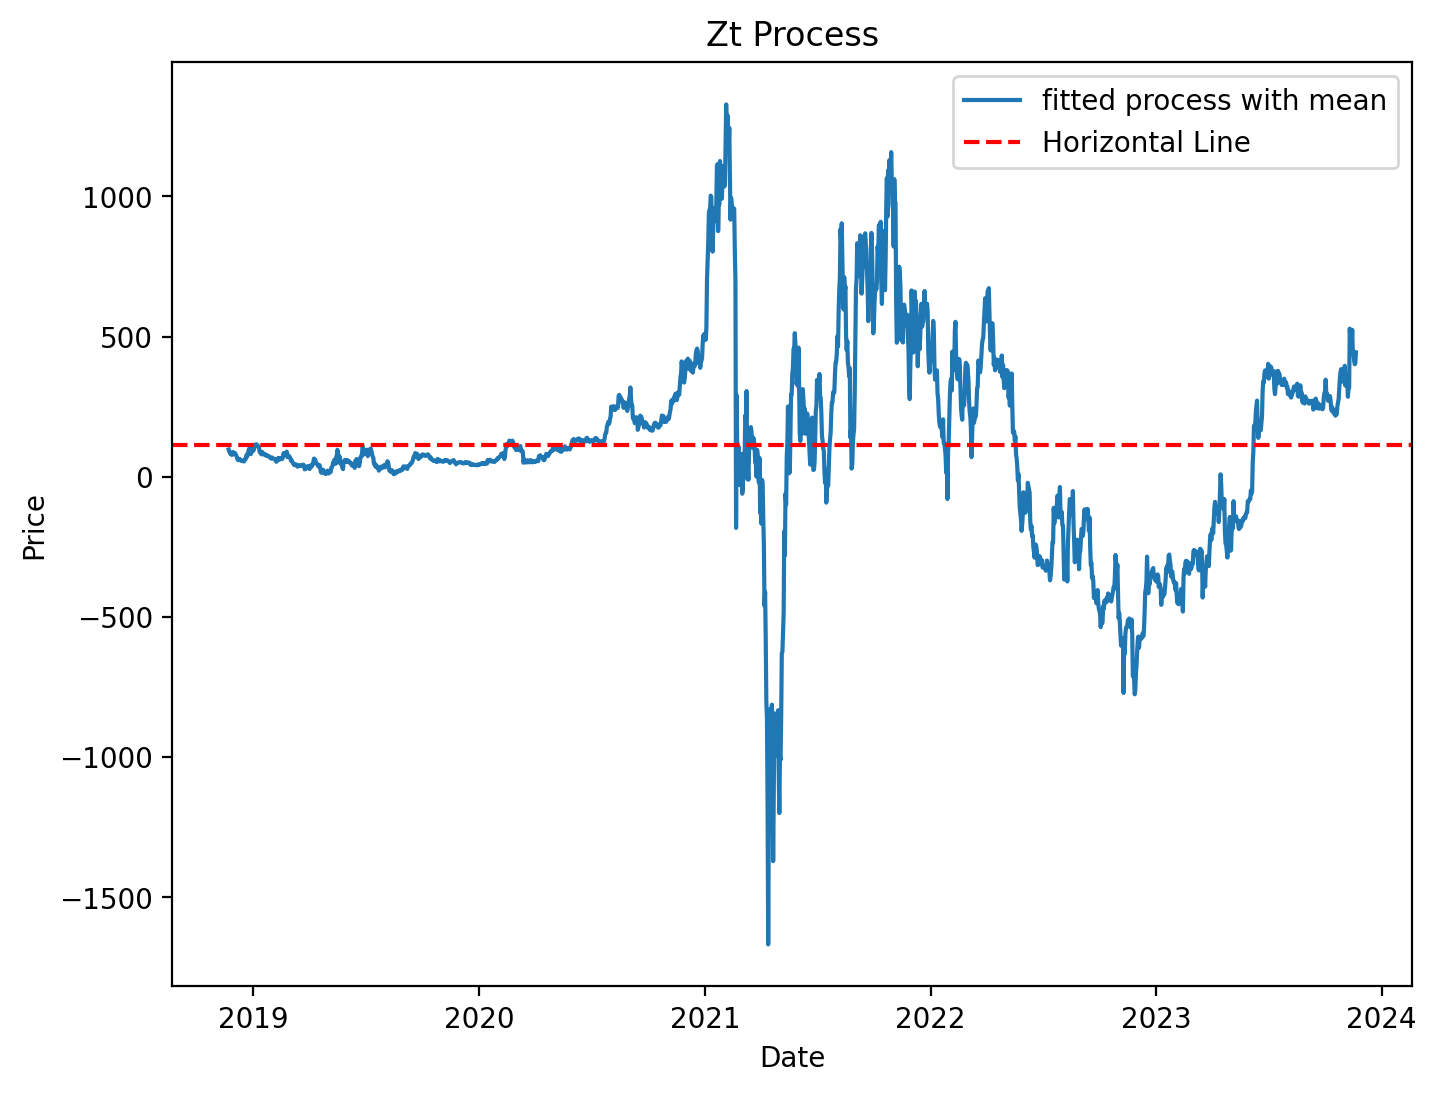

In [61]:
zt = eth - cointegration_coefficient*bnb
plt.figure(figsize=(8, 6),dpi = 200)
plt.plot(zt,label ='fitted process with mean')
#plt.plot(residuals,label = 'residuals')
plt.axhline(y=model.params['const'], color='red', linestyle='--', label='Horizontal Line')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.title("Zt Process")

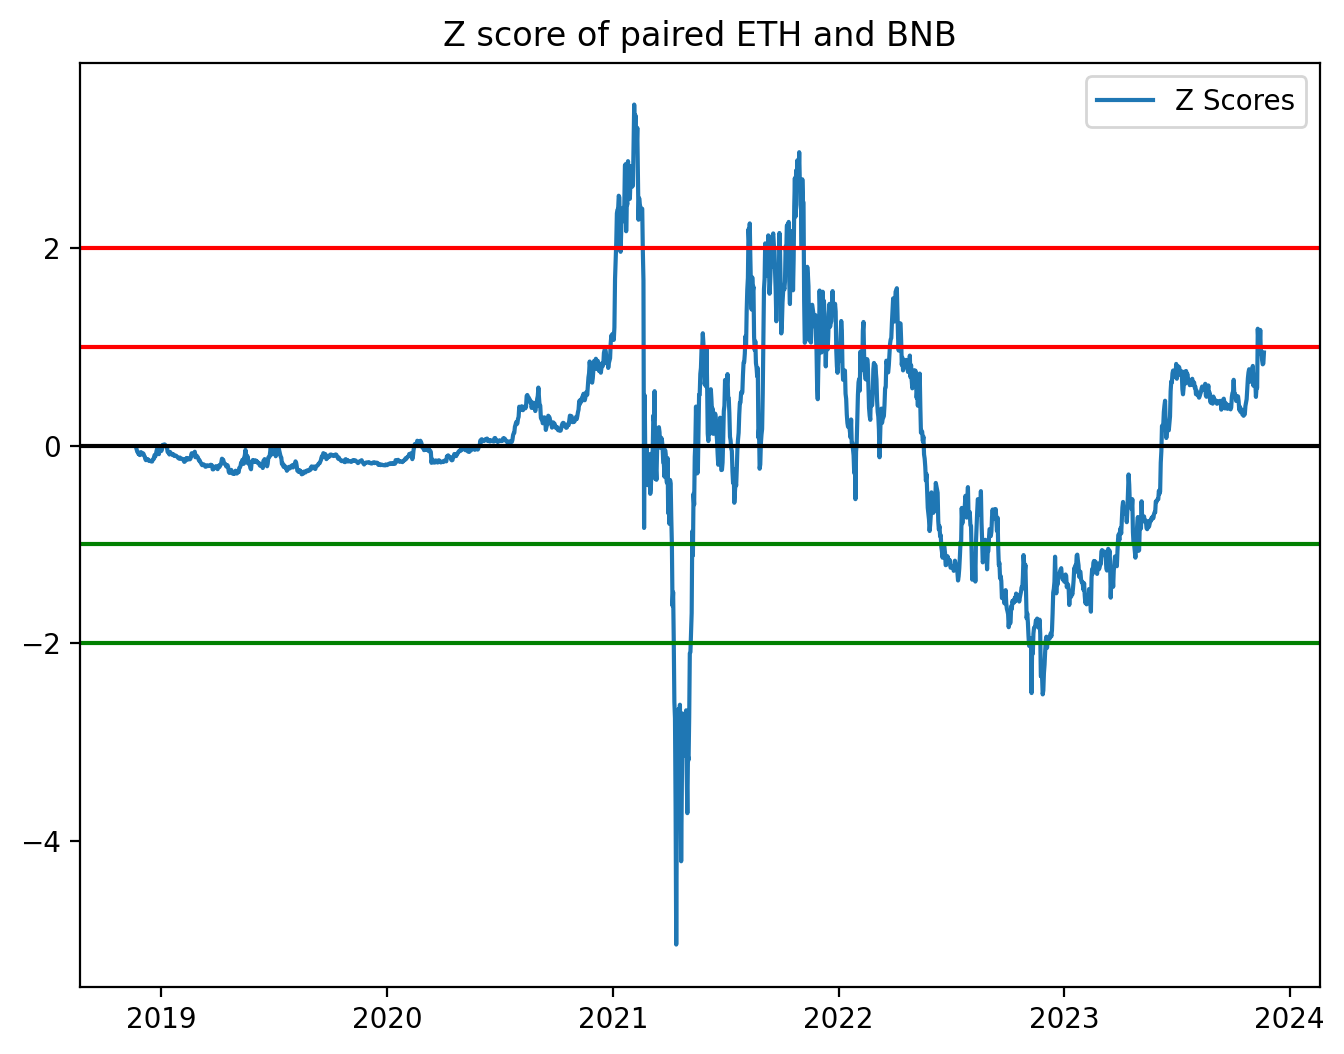

In [63]:
plt.figure(figsize=(8, 6),dpi = 200)
# Calculate the zt_score (standardisation of time series zt)

zt_zscore = (zt - zt.mean())/zt.std()
plt.plot(zt_zscore, label = "Z Scores")
plt.axhline(zt_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(2, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-2, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of paired ETH and BNB')
plt.show()

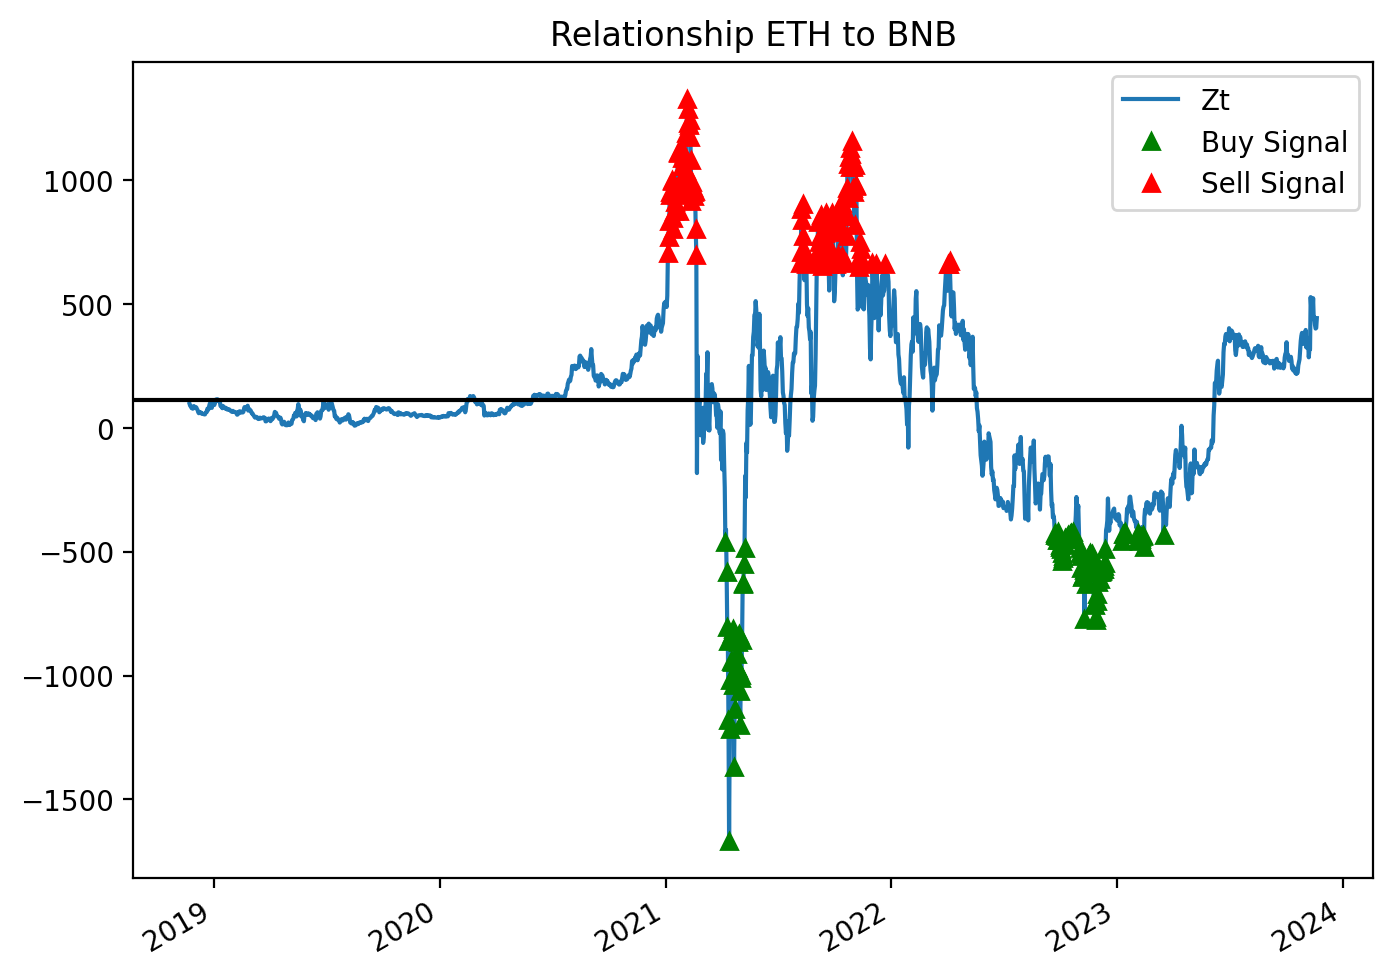

In [31]:
plt.figure(figsize=(8, 6),dpi = 200)
buy = zt.copy()
sell = zt.copy()

#If zscore_20_5 < -1, we buy. If zscore_20_5 > 1, we sell. If -1 < zscore_20_5 < 1, we hold. 
#buy[zscore_20_5>-1] = 0 #-1 and below we buy
#sell[zscore_20_5<1] = 0 # 1 and above we sell

buy[zt_zscore > -1.5] = 0 #-1 and below we buy
sell[zt_zscore < 1.5] = 0 # 1 and above we sell

zt.plot()
buy[buy!=0].plot(color='g', linestyle='None', marker='^')
sell[sell!=0].plot(color='r', linestyle='None', marker='^')
plt.axhline(zt.mean(), color = 'black')
plt.legend(['Zt', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship ETH to BNB')
plt.show()

In [45]:
bnb_returns = np.log(bnb/bnb.shift(1))
eth_returns = np.log(eth/eth.shift(1))

#zt_returns = np.log(zt/zt.shift(1))

test = pd.concat([zt_zscore,eth,bnb,eth_returns,bnb_returns,buy,sell], axis=1)
test.columns = ['zt score','ETH', 'BNB', 'ETH RETURNS', 'BNB RETURNS','BUY','SELL']
test['long'] = np.where(test['BUY'] != 0, 1, 0)
test['short'] = np.where(test['SELL'] != 0, -1, 0)
test['net'] = test['long'] + test['short']

In [46]:
test.head(20)

,zt score,ETH,BNB,ETH RETURNS,BNB RETURNS,BUY,SELL,long,short,net
2018-11-22 08:00:00,-0.040846,137.173043,6.229547,NaN,NaN,0.0,0.0,0,0,0
2018-11-23 08:00:00,-0.063243,126.066388,5.724390,-0.084435,-0.084568,0.0,0.0,0,0,0
2018-11-24 08:00:00,-0.066846,124.150296,5.622807,-0.015316,-0.017905,0.0,0.0,0,0,0
2018-11-25 08:00:00,-0.086496,114.287931,5.161089,-0.082772,-0.085683,0.0,0.0,0,0,0
2018-11-26 08:00:00,-0.078212,117.525278,5.211160,0.027932,0.009655,0.0,0.0,0,0,0
2018-11-27 08:00:00,-0.096272,109.430989,4.939163,-0.071359,-0.053607,0.0,0.0,0,0,0
2018-11-28 08:00:00,-0.093486,110.434944,4.942659,0.009132,0.000708,0.0,0.0,0,0,0
2018-11-29 08:00:00,-0.066310,122.446425,5.325495,0.103247,0.074602,0.0,0.0,0,0,0
2018-11-30 08:00:00,-0.080120,117.705386,5.345066,-0.039489,0.003668,0.0,0.0,0,0,0
2018-12-01 08:00:00,-0.087452,113.402883,5.074958,-0.037238,-0.051856,0.0,0.0,0,0,0


In [ ]:
#Does nothing
#plt.figure(figsize=(8, 6),dpi = 200)

#plt.plot(test['zt'])
#buy_v2 = zt.copy()
#sell_v2 = zt.copy()
#buy_v2 = test['zt'] [test['net'] == 1]
#sell_v2 = test['zt'][test['net'] == -1]
#buy_v2.plot(color='g', linestyle='None', marker='^')
#sell_v2.plot(color='r', linestyle='None', marker='^')
#plt.legend(['Zt', 'Buy_V2 Signal', 'Sell_V2 Signal'])

#len(buy_v2), len(buy), len(sell_v2), len(sell)

In [47]:
test['test'] =np.where(test['net']==0,np.nan,test['net'])
test['test'] = np.where(test['zt score']*test['zt score'].shift(1) < 0 , 0 ,test['test'])

test.head(30)

,zt score,ETH,BNB,ETH RETURNS,BNB RETURNS,BUY,SELL,long,short,net,test
2018-11-22 08:00:00,-0.040846,137.173043,6.229547,NaN,NaN,0.0,0.0,0,0,0,NaN
2018-11-23 08:00:00,-0.063243,126.066388,5.724390,-0.084435,-0.084568,0.0,0.0,0,0,0,NaN
2018-11-24 08:00:00,-0.066846,124.150296,5.622807,-0.015316,-0.017905,0.0,0.0,0,0,0,NaN
2018-11-25 08:00:00,-0.086496,114.287931,5.161089,-0.082772,-0.085683,0.0,0.0,0,0,0,NaN
2018-11-26 08:00:00,-0.078212,117.525278,5.211160,0.027932,0.009655,0.0,0.0,0,0,0,NaN
2018-11-27 08:00:00,-0.096272,109.430989,4.939163,-0.071359,-0.053607,0.0,0.0,0,0,0,NaN
2018-11-28 08:00:00,-0.093486,110.434944,4.942659,0.009132,0.000708,0.0,0.0,0,0,0,NaN
2018-11-29 08:00:00,-0.066310,122.446425,5.325495,0.103247,0.074602,0.0,0.0,0,0,0,NaN
2018-11-30 08:00:00,-0.080120,117.705386,5.345066,-0.039489,0.003668,0.0,0.0,0,0,0,NaN
2018-12-01 08:00:00,-0.087452,113.402883,5.074958,-0.037238,-0.051856,0.0,0.0,0,0,0,NaN


In [49]:
test['test'] = test['test'].fillna(method = 'ffill')
test['test'] = test['test'].fillna(0)

test.head(30)

,zt score,ETH,BNB,ETH RETURNS,BNB RETURNS,BUY,SELL,long,short,net,test
2018-11-22 08:00:00,-0.040846,137.173043,6.229547,NaN,NaN,0.0,0.0,0,0,0,0.0
2018-11-23 08:00:00,-0.063243,126.066388,5.724390,-0.084435,-0.084568,0.0,0.0,0,0,0,0.0
2018-11-24 08:00:00,-0.066846,124.150296,5.622807,-0.015316,-0.017905,0.0,0.0,0,0,0,0.0
2018-11-25 08:00:00,-0.086496,114.287931,5.161089,-0.082772,-0.085683,0.0,0.0,0,0,0,0.0
2018-11-26 08:00:00,-0.078212,117.525278,5.211160,0.027932,0.009655,0.0,0.0,0,0,0,0.0
2018-11-27 08:00:00,-0.096272,109.430989,4.939163,-0.071359,-0.053607,0.0,0.0,0,0,0,0.0
2018-11-28 08:00:00,-0.093486,110.434944,4.942659,0.009132,0.000708,0.0,0.0,0,0,0,0.0
2018-11-29 08:00:00,-0.066310,122.446425,5.325495,0.103247,0.074602,0.0,0.0,0,0,0,0.0
2018-11-30 08:00:00,-0.080120,117.705386,5.345066,-0.039489,0.003668,0.0,0.0,0,0,0,0.0
2018-12-01 08:00:00,-0.087452,113.402883,5.074958,-0.037238,-0.051856,0.0,0.0,0,0,0,0.0


In [56]:
test['gain_loss'] = (0.5*test['ETH RETURNS'] - 0.5*test['BNB RETURNS'])*test['test']
test['total'] = test['gain_loss'].cumsum()
test['actual_returns'] = np.exp(test['total']) - 1

In [57]:
test.tail(20)

,zt score,ETH,BNB,ETH RETURNS,BNB RETURNS,BUY,SELL,long,short,net,test,gain_loss,total,actual_returns,Account
2023-11-01 08:00:00,0.745546,1816.803149,226.565416,0.003951,-0.007103,0.0,0.0,0,0,0,0.0,0.0,0.771791,1.163639,468133.227583
2023-11-02 08:00:00,0.806055,1846.482231,227.878762,0.016204,0.005780,0.0,0.0,0,0,0,0.0,0.0,0.771791,1.163639,468133.227583
2023-11-03 08:00:00,0.605342,1800.907180,231.828266,-0.024992,0.017183,0.0,0.0,0,0,0,0.0,-0.0,0.771791,1.163639,468133.227583
2023-11-04 08:00:00,0.719134,1834.173057,230.755983,0.018303,-0.004636,0.0,0.0,0,0,0,0.0,0.0,0.771791,1.163639,468133.227583
2023-11-05 08:00:00,0.661446,1855.454385,237.292136,0.011536,0.027931,0.0,0.0,0,0,0,0.0,-0.0,0.771791,1.163639,468133.227583
2023-11-06 08:00:00,0.649250,1895.938066,244.326915,0.021584,0.029215,0.0,0.0,0,0,0,0.0,-0.0,0.771791,1.163639,468133.227583
2023-11-07 08:00:00,0.492548,1898.518226,253.405494,0.001360,0.036484,0.0,0.0,0,0,0,0.0,-0.0,0.771791,1.163639,468133.227583
2023-11-08 08:00:00,0.591020,1887.315322,246.195291,-0.005918,-0.028866,0.0,0.0,0,0,0,0.0,0.0,0.771791,1.163639,468133.227583
2023-11-09 08:00:00,0.582844,1891.491779,247.303903,0.002210,0.004493,0.0,0.0,0,0,0,0.0,-0.0,0.771791,1.163639,468133.227583
2023-11-10 08:00:00,1.182482,2128.609504,251.364833,0.118103,0.016287,0.0,0.0,0,0,0,0.0,0.0,0.771791,1.163639,468133.227583


In [58]:
test['Account'] = 100000*(test['actual_returns'] +1) 

In [59]:
test.tail(20)

,zt score,ETH,BNB,ETH RETURNS,BNB RETURNS,BUY,SELL,long,short,net,test,gain_loss,total,actual_returns,Account
2023-11-01 08:00:00,0.745546,1816.803149,226.565416,0.003951,-0.007103,0.0,0.0,0,0,0,0.0,0.0,0.771791,1.163639,216363.866573
2023-11-02 08:00:00,0.806055,1846.482231,227.878762,0.016204,0.005780,0.0,0.0,0,0,0,0.0,0.0,0.771791,1.163639,216363.866573
2023-11-03 08:00:00,0.605342,1800.907180,231.828266,-0.024992,0.017183,0.0,0.0,0,0,0,0.0,-0.0,0.771791,1.163639,216363.866573
2023-11-04 08:00:00,0.719134,1834.173057,230.755983,0.018303,-0.004636,0.0,0.0,0,0,0,0.0,0.0,0.771791,1.163639,216363.866573
2023-11-05 08:00:00,0.661446,1855.454385,237.292136,0.011536,0.027931,0.0,0.0,0,0,0,0.0,-0.0,0.771791,1.163639,216363.866573
2023-11-06 08:00:00,0.649250,1895.938066,244.326915,0.021584,0.029215,0.0,0.0,0,0,0,0.0,-0.0,0.771791,1.163639,216363.866573
2023-11-07 08:00:00,0.492548,1898.518226,253.405494,0.001360,0.036484,0.0,0.0,0,0,0,0.0,-0.0,0.771791,1.163639,216363.866573
2023-11-08 08:00:00,0.591020,1887.315322,246.195291,-0.005918,-0.028866,0.0,0.0,0,0,0,0.0,0.0,0.771791,1.163639,216363.866573
2023-11-09 08:00:00,0.582844,1891.491779,247.303903,0.002210,0.004493,0.0,0.0,0,0,0,0.0,-0.0,0.771791,1.163639,216363.866573
2023-11-10 08:00:00,1.182482,2128.609504,251.364833,0.118103,0.016287,0.0,0.0,0,0,0,0.0,0.0,0.771791,1.163639,216363.866573


Text(0, 0.5, 'Balance')

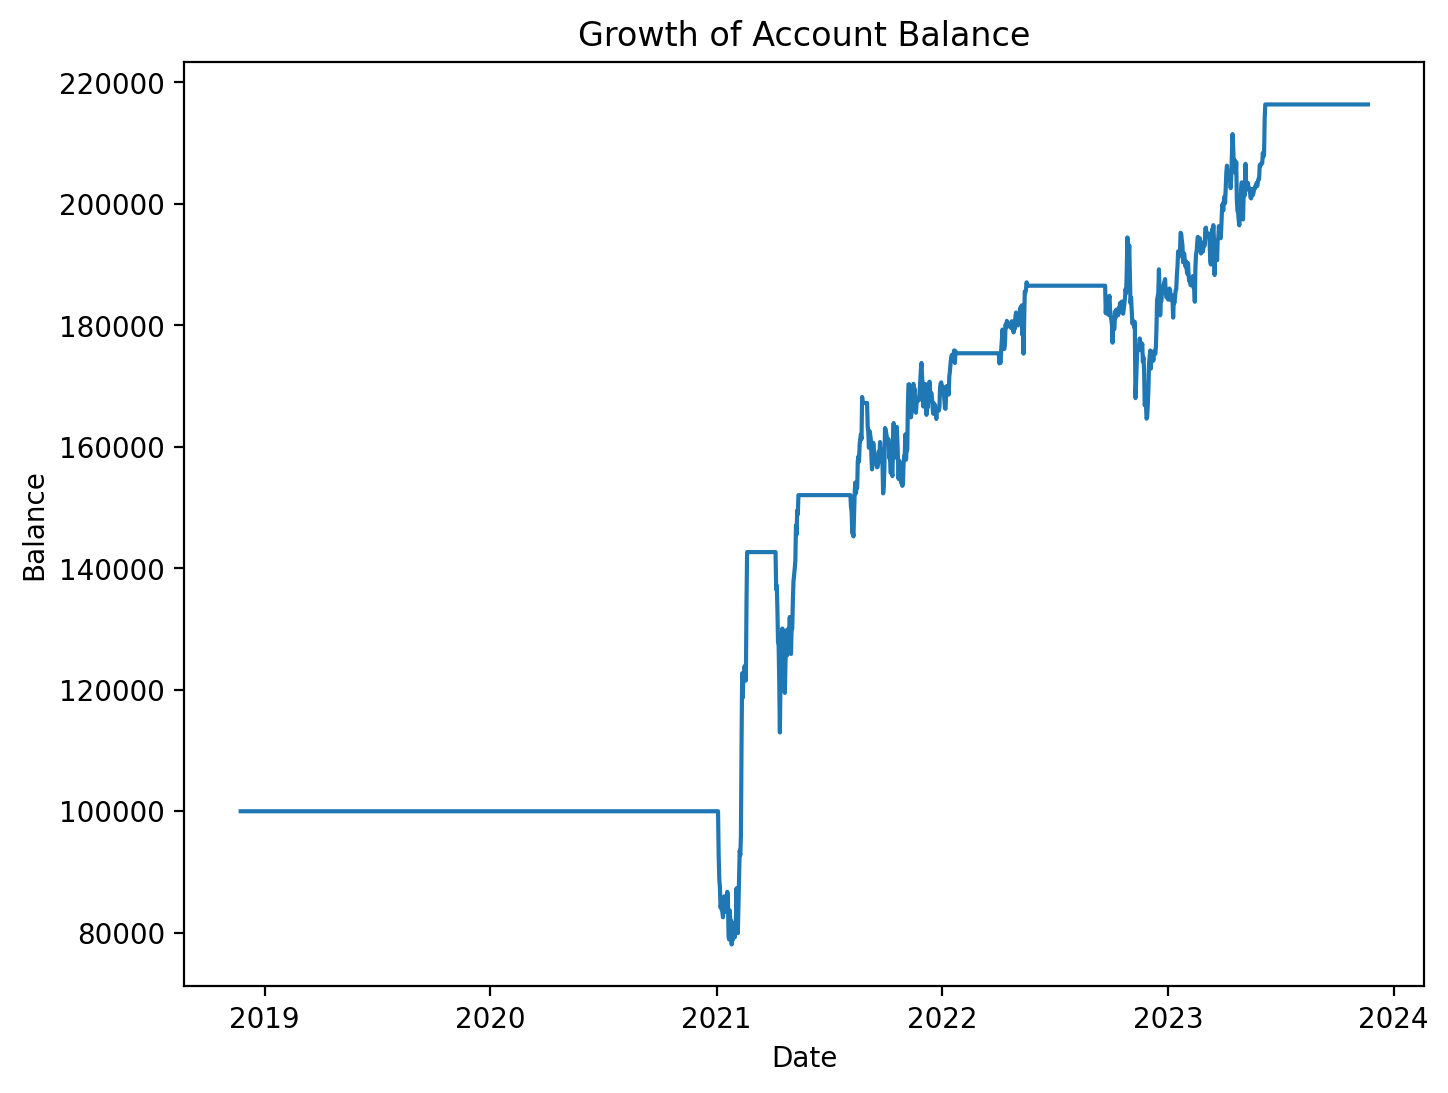

In [64]:
plt.figure(figsize=(8, 6),dpi = 200)
plt.title('Growth of Account Balance')
plt.plot(test['Account'])
plt.xlabel('Date')
plt.ylabel('Balance')

In [65]:
daily_return = test['Account'].pct_change()
average_daily_return = daily_return.mean()
volatility = daily_return.std()

annualized_return = (1 + average_daily_return)**252 - 1
annualized_volatility = volatility * np.sqrt(252)

print("Annualized Return:", annualized_return)
print("Annualized Volatility:", annualized_volatility)

Annualized Return: 0.1274989342430548
Annualized Volatility: 0.1648369505566453


In [67]:
sharpe = (annualized_return - 0.04)/annualized_volatility
print(sharpe)

0.5308211171559273
